In [23]:
%pip install pip install pydot


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE


data_dir = "alzheimer"
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
print(os.listdir(data_dir))

2024-05-08 12:51:57.745445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 12:51:58.692861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


['train', 'test']


In [2]:
images = []
labels = []
for subfolder in tqdm(os.listdir('alzheimer')):
    subfolder_path = os.path.join('alzheimer', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00, 232.20it/s]


,image,label
0,alzheimer/train/ModerateDemented/moderateDem20...,ModerateDemented
1,alzheimer/train/ModerateDemented/moderateDem3.jpg,ModerateDemented
2,alzheimer/train/ModerateDemented/moderateDem44...,ModerateDemented
3,alzheimer/train/ModerateDemented/moderateDem45...,ModerateDemented
4,alzheimer/train/ModerateDemented/moderateDem17...,ModerateDemented
...,...,...
6399,alzheimer/test/MildDemented/28 (26).jpg,MildDemented
6400,alzheimer/test/MildDemented/29 (12).jpg,MildDemented
6401,alzheimer/test/MildDemented/31 (4).jpg,MildDemented
6402,alzheimer/test/MildDemented/31 (8).jpg,MildDemented


/tmp/ipykernel_119934/2491139483.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label,palette='Set2')


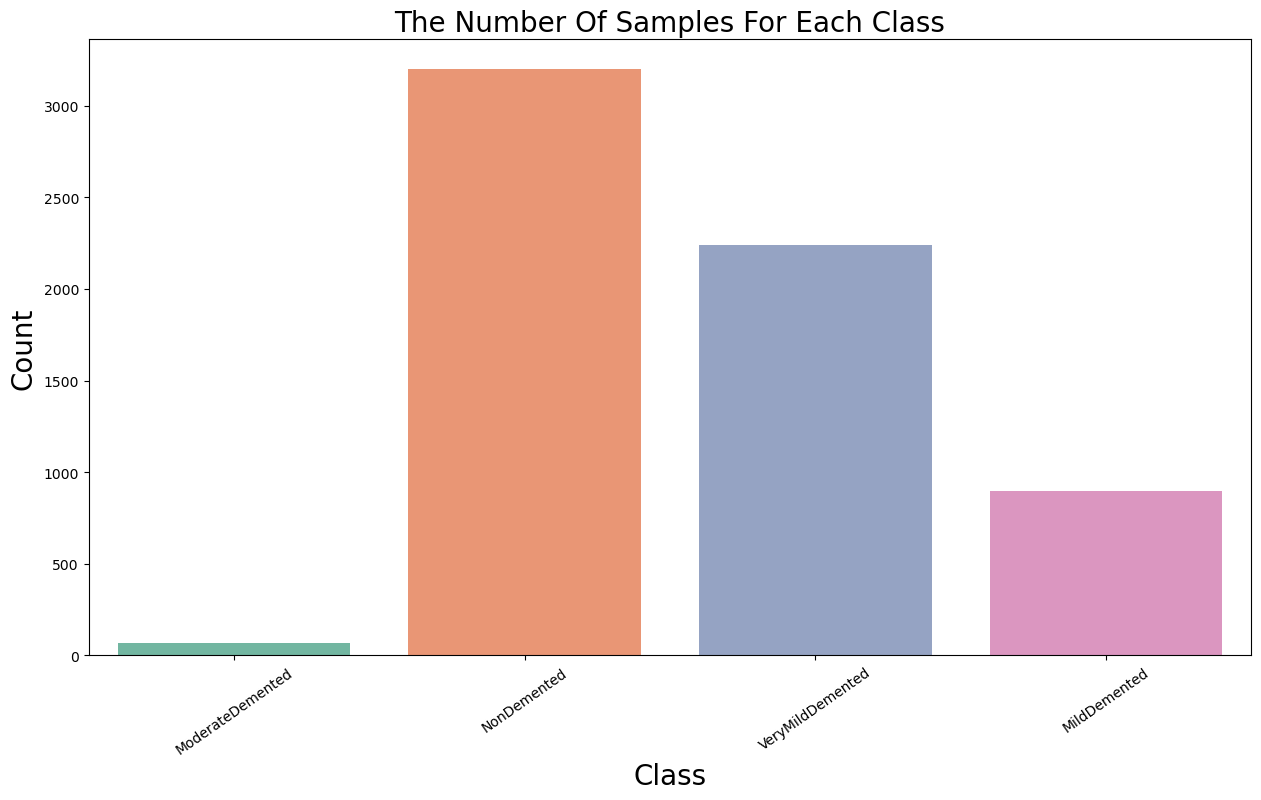

In [3]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set2')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)
plt.show()

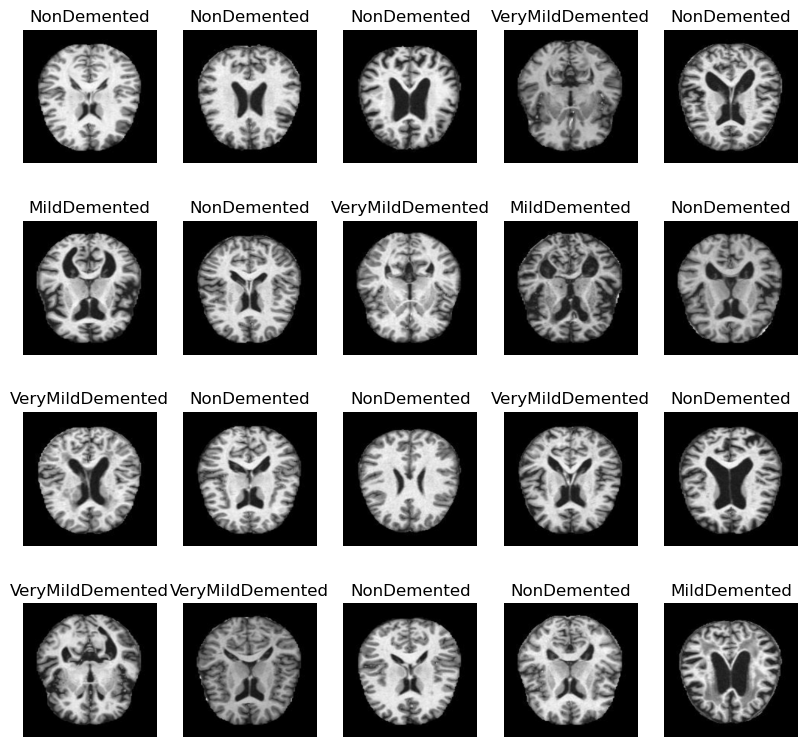

In [4]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=12)

In [5]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


/opt/conda/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 4 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [6]:
train_data, train_labels = next(train_data_gen)
print(train_data.shape, train_labels.shape)
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

(6400, 176, 176, 3) (6400, 4)


array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

(12800, 176, 176, 3) (12800, 4)


/tmp/ipykernel_119934/4127951069.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=labels,palette='Set2')


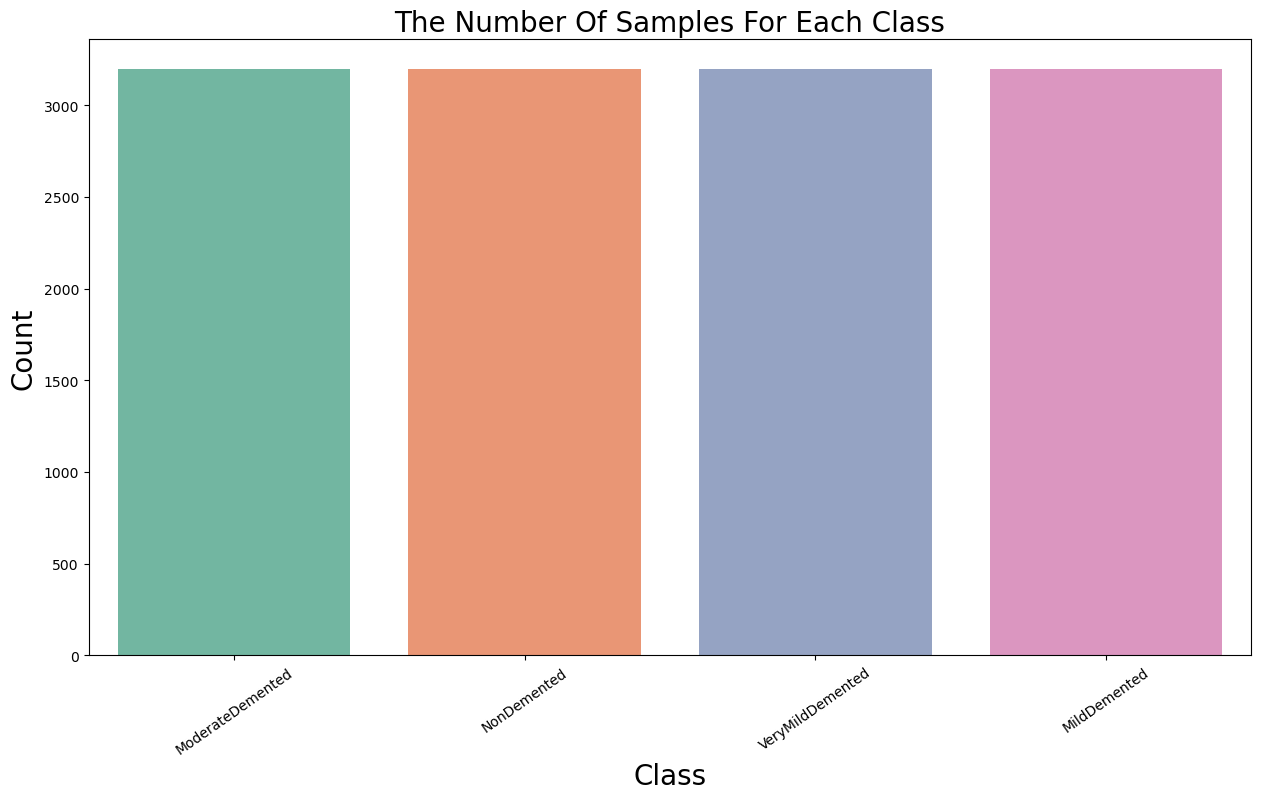

In [7]:
import imblearn
smote = imblearn.over_sampling.SMOTE(random_state=42)
train_data, train_labels = smote.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set2')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)
plt.show()

In [10]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import wandb
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Input, Activation

from tensorflow.keras.utils import to_categorical


from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Setup wandb configuration
def setup_wandb():
    wandb.init(project="computer_vision", config={
        "learning_rate": 0.00001,
        "architecture": "ResNet50",
        "dataset": "alzheimer",
        "epochs": 30,
        "batch_size": 16,
        "input_shape": (176, 176, 3),  # Updated input shape
        "num_classes": 4
    })
    return wandb.config

config = setup_wandb()

import tensorflow as tf


X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)

y_train_one_hot = to_categorical(y_train, num_classes=len(classes))
y_val_one_hot = to_categorical(y_val, num_classes=len(classes))
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

def create_resnet_model(config):
    # Load the ResNet50 model with pre-trained ImageNet weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=config.input_shape)
    
    # Freezing the initial layers to maintain pre-trained features
    for layer in base_model.layers[:-10]:  # Freeze all except the last 25 layers
        layer.trainable = False

    # Model augmentation for specific task
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reduce dimensions while maintaining spatial hierarchies
    
    # Fully connected layers for classification on new data
    x = Dense(128, use_bias=False)(x)  # Use bias=False with BatchNormalization
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Activation('relu')(x)
    
    x = Dense(64, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Activation('relu')(x)
    
    x = Dense(32, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output layer
    predictions = Dense(config.num_classes, activation='softmax')(x)
    
    # Compile model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_resnet_model(config)

class CustomWandbCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        wandb.log({
            'epoch': epoch,
            'loss': logs.get('loss'),
            'accuracy': logs.get('accuracy'),
            'val_loss': logs.get('val_loss'),
            'val_accuracy': logs.get('val_accuracy')
        })

# Customizing the Adam optimizer with specific beta_1, beta_2, and epsilon values
optimizer = Adam(
    learning_rate=config.learning_rate,  # Ensure 'config.learning_rate' is defined previously
)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)


final_checkpoint = 'final_best_model.keras'
final_checkpoint_callback = ModelCheckpoint(final_checkpoint, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size,
                    validation_data=(X_val, y_val), callbacks=[final_checkpoint_callback])


best_final_model = tf.keras.models.load_model(final_checkpoint)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Final Test loss: {test_loss}, Test accuracy: {test_accuracy}')

wandb.log({'final_test_loss': test_loss, 'final_test_accuracy': test_accuracy})

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 182, 182,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 88, 88,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 88, 88,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 88, 88,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 90, 90,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 44, 44,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 44, 44,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 44, 44,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 44, 44,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 44, 44,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 44, 44,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 44, 44,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 44, 44,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 44, 44,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 44, 44,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 44, 44,    │      1,024 │ conv2_block1_3_c

 Total params: 23,861,124 (91.02 MB)

 Trainable params: 4,738,628 (18.08 MB)

 Non-trainable params: 19,122,496 (72.95 MB)

Epoch 1/30


I0000 00:00:1715180553.265553  120610 service.cc:145] XLA service 0x7fd8500044a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715180553.265600  120610 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM3-32GB, Compute Capability 7.0
2024-05-08 15:02:33.557408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-08 15:02:34.631261: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8905


  7/560 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1414 - loss: 1.7960 

I0000 00:00:1715180559.773746  120610 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3777 - loss: 1.4087
Epoch 1: val_accuracy improved from -inf to 0.57187, saving model to final_best_model.keras
560/560 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.3779 - loss: 1.4085 - val_accuracy: 0.5719 - val_loss: 0.9944
Epoch 2/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5526 - loss: 1.0967
Epoch 2: val_accuracy improved from 0.57187 to 0.66354, saving model to final_best_model.keras
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.5527 - loss: 1.0966 - val_accuracy: 0.6635 - val_loss: 0.8565
Epoch 3/30
558/560 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6141 - loss: 0.9768
Epoch 3: val_accuracy improved from 0.66354 to 0.68750, saving model to final_best_model.keras
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.6142 - loss: 0.9767 - val_accuracy: 0.6875 - val_loss: 0.7875
Epoch 4/30
558/560 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6368 - loss: 0.9109
Epoch 4: val_accuracy im

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


<Figure size 800x600 with 0 Axes>

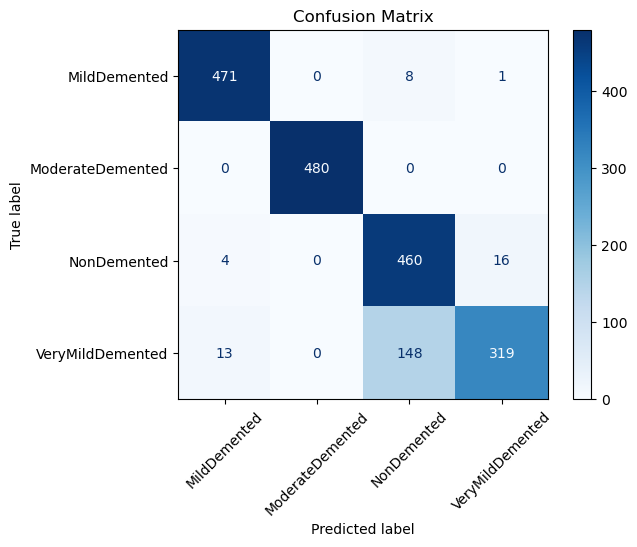

                  precision    recall  f1-score   support

    MildDemented       0.97      0.98      0.97       480
ModerateDemented       1.00      1.00      1.00       480
     NonDemented       0.75      0.96      0.84       480
VeryMildDemented       0.95      0.66      0.78       480

        accuracy                           0.90      1920
       macro avg       0.92      0.90      0.90      1920
    weighted avg       0.92      0.90      0.90      1920



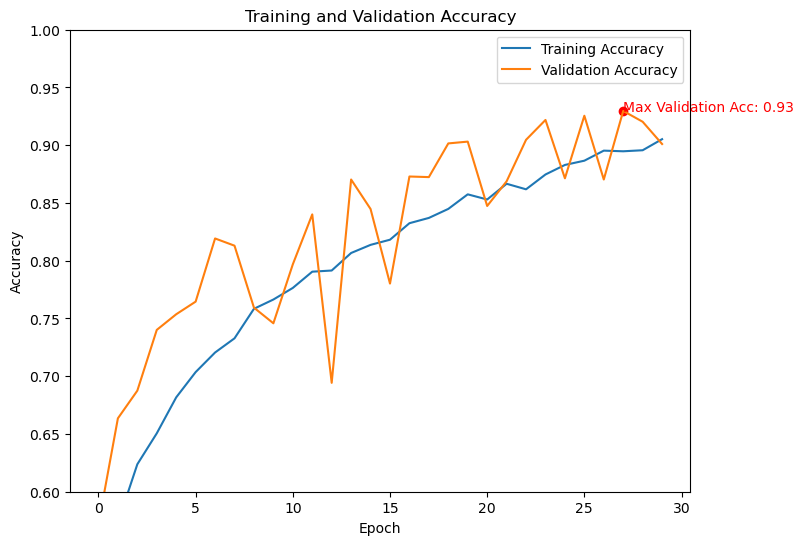

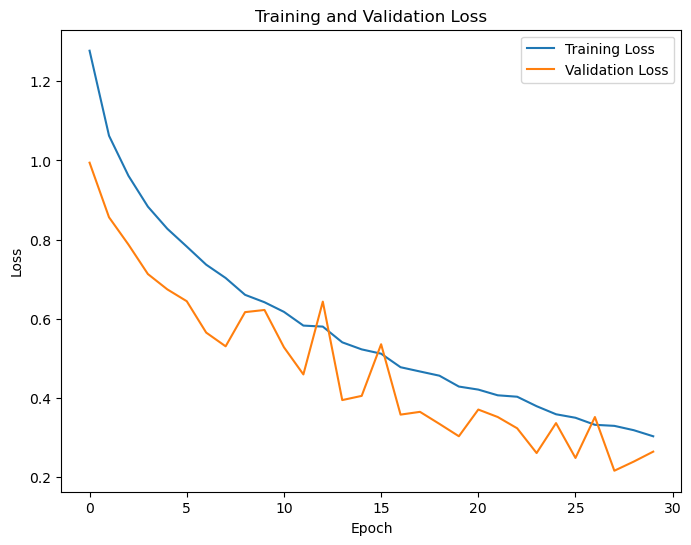

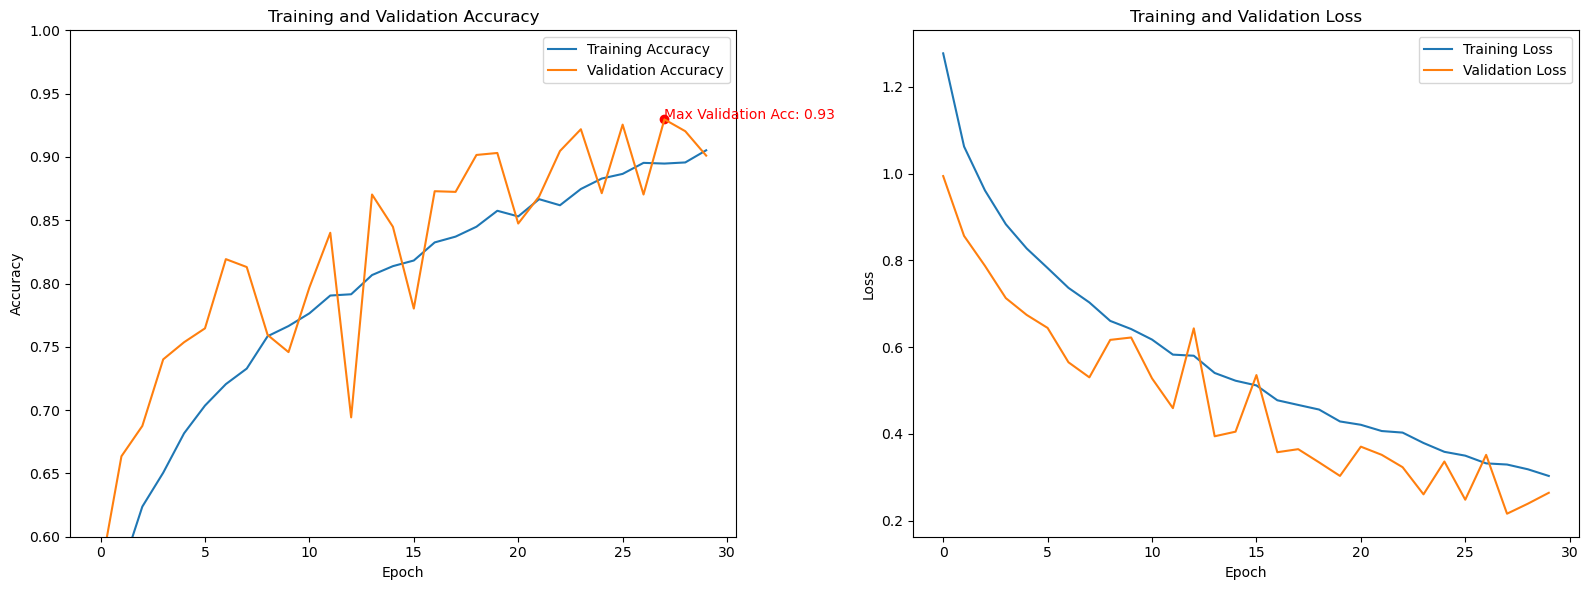

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# Assuming your model's output is categorical, get the class with the highest probability
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# If y_test is one-hot encoded, convert it back to class indices
y_test_classes = np.argmax(y_test, axis=1)
# Generate and plot the confusion matrix
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=classes))
# Plot training and validation accuracy

# Training and Validation Accuracy Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# Highlight the maximum validation accuracy
max_val_acc = np.max(history.history['val_accuracy'])
max_val_epoch = np.argmax(history.history['val_accuracy'])
plt.scatter(max_val_epoch, max_val_acc, color='red')  # Mark the max point
plt.text(max_val_epoch, max_val_acc, f'Max Validation Acc: {max_val_acc:.2f}', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.6, 1])
plt.show()

# Training and Validation Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Training and Validation Accuracy Plot on the first subplot
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
# Highlight the maximum validation accuracy
max_val_acc = np.max(history.history['val_accuracy'])
max_val_epoch = np.argmax(history.history['val_accuracy'])
ax1.scatter(max_val_epoch, max_val_acc, color='red')  # Mark the max point
ax1.text(max_val_epoch, max_val_acc, f'Max Validation Acc: {max_val_acc:.2f}', color='red')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_ylim([0.6, 1])

# Training and Validation Loss Plot on the second subplot
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Display the plots
plt.tight_layout()  # Adjust the layout to make sure everything fits without overlap
plt.show()

Found 1301 images belonging to 4 classes.


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
Number of predictions: 1301
Number of true labels: 1301


<Figure size 1000x800 with 0 Axes>

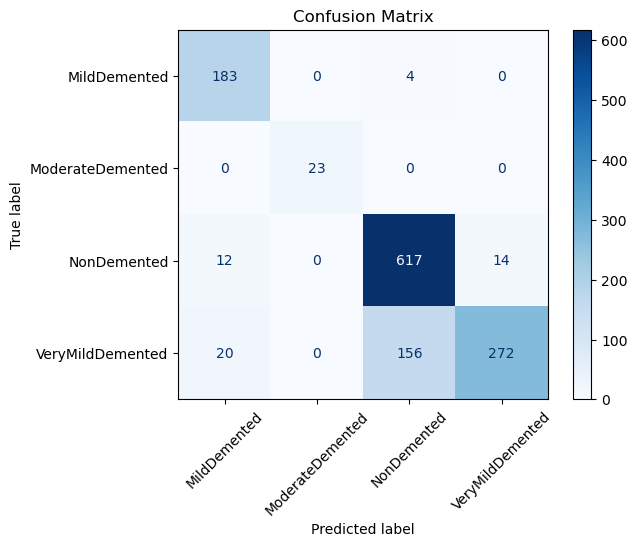

                  precision    recall  f1-score   support

    MildDemented       0.85      0.98      0.91       187
ModerateDemented       1.00      1.00      1.00        23
     NonDemented       0.79      0.96      0.87       643
VeryMildDemented       0.95      0.61      0.74       448

        accuracy                           0.84      1301
       macro avg       0.90      0.89      0.88      1301
    weighted avg       0.86      0.84      0.83      1301



In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import math

# Setup the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'alzheimer/test',
    target_size=config.input_shape[:2],
    batch_size=config.batch_size,
    class_mode='categorical',
    shuffle=False  # It's important not to shuffle for evaluation to match labels
)

# Calculate the number of steps needed to cover all samples in the test set exactly once
steps = math.ceil(test_generator.n / test_generator.batch_size)

# Resetting the generator to ensure the order of prediction
test_generator.reset()

# Use the calculated steps to predict
y_pred = model.predict(test_generator, steps=steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Getting the true labels from the generator
y_true = test_generator.classes

# Ensure that the number of predictions and true labels match
print("Number of predictions:", len(y_pred_classes))
print("Number of true labels:", len(y_true))

# Generate and display the confusion matrix
classes = list(test_generator.class_indices.keys())  # Fetching class labels from the generator
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes, target_names=classes))


### Sweep

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import wandb

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'min': 0.00001,
            'max': 0.001
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'optimizer': {
            'values': ['adam']
        },
        'dropout_rate': {
            'values': [0.0, 0.2, 0.5]
        },
        'beta_1': {
            'min': 0.80,
            'max': 0.95
        },
        'beta_2': {
            'min': 0.990,
            'max': 0.999
        },
        'epsilon': {
            'min': 1e-9,
            'max': 1e-7
        },
        'epochs': {
            'values': [50, 100,1000, 2000]
        },
        'rotation_range': {
            'values': [10, 20, 30]
        },
        'width_shift_range': {
            'values': [0.1, 0.2, 0.3]
        },
        'height_shift_range': {
            'values': [0.1, 0.2, 0.3]
        },
        'brightness_range_min': {
            'values': [0.8, 0.7, 0.6]
        },
        'brightness_range_max': {
            'values': [1.2, 1.3, 1.4]
        },
        'shear_range': {
            'values': [0.2, 0.3, 0.4]
        },
        'class_weight_non_demented': {
            'values': [1.0, 1.1, 1.2]
        },
        'class_weight_very_mild': {
            'values': [1.7, 1.8, 1.9]
        },
        'class_weight_mild': {
            'values': [1.7, 1.8, 1.9]
        },
        'class_weight_moderate': {
            'values': [1.0, 0.9, 0.8]
        }
    }
}

def create_resnet_model(config):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(176, 208, 3))
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(config.dropout_rate)(x)  # Add dropout
    x = layers.Dense(128, activation='relu')(x)
    predictions = layers.Dense(4, activation='softmax')(x)
    return Model(inputs=base_model.inputs, outputs=predictions)

class CustomWandbCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        wandb.log(logs)


def train():
    wandb.init()
    config = wandb.config
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=config.rotation_range,
        width_shift_range=config.width_shift_range,
        height_shift_range=config.height_shift_range,
        brightness_range=[config.brightness_range_min, config.brightness_range_max],
        shear_range=config.shear_range
    )
    train_generator = train_datagen.flow_from_directory(
        'alzheimer/train',
        target_size=(176, 208),
        batch_size=config.batch_size,
        class_mode='categorical'
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        'alzheimer/test',
        target_size=(176, 208),
        batch_size=config.batch_size,
        class_mode='categorical'
    )

    model = create_resnet_model(config)
    
    if config.optimizer == 'adam':
        optimizer = Adam(
            learning_rate=config.learning_rate,
            beta_1=config.beta_1,
            beta_2=config.beta_2,
            epsilon=config.epsilon
        )
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=config.learning_rate)



    model_dir = 'model'
    os.makedirs(model_dir, exist_ok=True)
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(model_dir, 'model_{epoch:02d}_{val_accuracy:.4f}.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='auto',
        save_freq='epoch'
    )
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


    class_weights = {
    0: config.class_weight_non_demented,   # Non Demented
    1: config.class_weight_very_mild,   # Very Mild Demented
    2: config.class_weight_mild,   # Mild Demented
    3: config.class_weight_moderate    # Moderate Demented
    }
    model.fit(
        train_generator,
        epochs=config.epochs,
        validation_data=test_generator,
        class_weight=class_weights,  # Ensure class weights are defined as part of your sweep config if necessary
        callbacks=[checkpoint_callback, CustomWandbCallback()]
    )
    
    wandb.run.finish()



In [ ]:
import wandb
sweep_id = wandb.sweep(sweep_config, project="computer_vision")
wandb.agent(sweep_id, train)


Create sweep with ID: wk0y4zss
Sweep URL: https://wandb.ai/ossyandlars/computer_vision/sweeps/wk0y4zss


wandb: Agent Starting Run: m3d9qwv0 with config:
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9223069143519266
wandb: 	beta_2: 0.9936927105871868
wandb: 	brightness_range_max: 1.2
wandb: 	brightness_range_min: 0.7
wandb: 	class_weight_mild: 1.8
wandb: 	class_weight_moderate: 1
wandb: 	class_weight_non_demented: 1.1
wandb: 	class_weight_very_mild: 1.9
wandb: 	dropout_rate: 0
wandb: 	epochs: 100
wandb: 	epsilon: 1.5884275914475305e-08
wandb: 	height_shift_range: 0.3
wandb: 	learning_rate: 0.00029124978427559617
wandb: 	optimizer: adam
wandb: 	rotation_range: 30
wandb: 	shear_range: 0.2
wandb: 	width_shift_range: 0.2
wandb: Currently logged in as: lemoi18 (ossyandlars). Use `wandb login --relogin` to force relogin


Found 5131 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


2024-04-28 18:13:59.804491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18337 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.20gb, pci bus id: 0000:21:00.0, compute capability: 8.0


Epoch 1/100


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714328046.284283  941188 service.cc:145] XLA service 0x7f5bb8015240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714328046.284344  941188 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.20gb, Compute Capability 8.0
2024-04-28 18:14:06.417910: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-28 18:14:06.949094: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8905
I0000 00:00:1714

 2/81 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.4609 - loss: 1.8201  

I0000 00:00:1714328058.644664  941188 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4956 - loss: 1.4082

I0000 00:00:1714328086.344957  942279 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1709', 244 bytes spill stores, 244 bytes spill loads



81/81 ━━━━━━━━━━━━━━━━━━━━ 51s 416ms/step - accuracy: 0.4957 - loss: 1.4078 - val_accuracy: 0.5004 - val_loss: 1.0169
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.4974 - loss: 1.3474 - val_accuracy: 0.5020 - val_loss: 0.9918
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.4997 - loss: 1.3240 - val_accuracy: 0.5004 - val_loss: 1.0095
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.5031 - loss: 1.3005 - val_accuracy: 0.5004 - val_loss: 1.0772
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.4993 - loss: 1.2965 - val_accuracy: 0.5004 - val_loss: 1.6427
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.4898 - loss: 1.2955 - val_accuracy: 0.5004 - val_loss: 1.2693
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.5036 - loss: 1.2793 - val_accuracy: 0.4691 - val_loss: 1.0386
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.4999 - loss: 1.2826 - val_accuracy

accuracy,▁▂▂▂▃▂▂▂▁▂▂▂▂▃▂▂▂▃▃▄▃▄▃▆▄▅▅▅▅▆█▆▄▆▅▆▄▇▇▅
loss,█▆▅▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁
val_accuracy,▇▇▇█▆▇▇▇▇▇▇▇▇▇▆▇▇▇▆▇▇▇▇█▇▁▇▇▇▇▇▇▇▇▇▇▇█▇▇
val_loss,▂▂▃▁▁▃▁▂▂▁▂▂▁▃▂▂▁▁▂▁▂▂▁▂█▄▁▁▁▄▄▁▇▁▆▁▂▁█▁
accuracy,0.51413
loss,1.17671
val_accuracy,0.52776
val_loss,0.94797


wandb: Agent Starting Run: jujmui4t with config:
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9032951302145308
wandb: 	beta_2: 0.9934229620440952
wandb: 	brightness_range_max: 1.2
wandb: 	brightness_range_min: 0.8
wandb: 	class_weight_mild: 1.8
wandb: 	class_weight_moderate: 0.8
wandb: 	class_weight_non_demented: 1.1
wandb: 	class_weight_very_mild: 1.8
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	epsilon: 6.295894053585252e-08
wandb: 	height_shift_range: 0.3
wandb: 	learning_rate: 0.000551057394911909
wandb: 	optimizer: adam
wandb: 	rotation_range: 10
wandb: 	shear_range: 0.3
wandb: 	width_shift_range: 0.1


Found 5131 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 298ms/step - accuracy: 0.4734 - loss: 1.3388 - val_accuracy: 0.5004 - val_loss: 2.3064
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.5033 - loss: 1.1741 - val_accuracy: 0.5004 - val_loss: 1.7536
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.4855 - loss: 1.1777 - val_accuracy: 0.5004 - val_loss: 2.0396
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.4979 - loss: 1.1314 - val_accuracy: 0.5004 - val_loss: 1.3590
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.4999 - loss: 1.1359 - val_accuracy: 0.5004 - val_loss: 1.7183
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.4944 - loss: 1.1281 - val_accuracy: 0.5004 - val_loss: 1.0237
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.4908 - loss: 1.1376 - val_accuracy: 0.5004 - val_loss: 0.9981
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.5040 - loss: 1.1005 - val_accuracy: 0.500

accuracy,▁▃▂▃▂▃▂▃▃▃▄▃▃▃▃▃▃▄▄▃▃▃▅▅▄▅▄▄▅▆▆▅▅▄▅▇▇█▇▇
loss,█▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▃▂▂▂▁▂▄▂▂▂▂▅▂█▃
val_loss,▄▃▃▂▁▁▂▄▁█▂▃▁▃▁▂▁▁▃▁▁▁▂▂▃▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁
accuracy,0.51004
loss,1.04025
val_accuracy,0.50977
val_loss,0.93588


wandb: Agent Starting Run: 7bmin05p with config:
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9099338330566514
wandb: 	beta_2: 0.9926923758140712
wandb: 	brightness_range_max: 1.4
wandb: 	brightness_range_min: 0.7
wandb: 	class_weight_mild: 1.9
wandb: 	class_weight_moderate: 0.9
wandb: 	class_weight_non_demented: 1.1
wandb: 	class_weight_very_mild: 1.9
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	epsilon: 2.709578435941659e-08
wandb: 	height_shift_range: 0.1
wandb: 	learning_rate: 4.432832600227937e-05
wandb: 	optimizer: adam
wandb: 	rotation_range: 10
wandb: 	shear_range: 0.2
wandb: 	width_shift_range: 0.3


Found 5131 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4865 - loss: 1.4092

I0000 00:00:1714331231.869613  983440 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1709', 4820 bytes spill stores, 5616 bytes spill loads

I0000 00:00:1714331234.915481  983602 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1709', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1714331235.018949  983577 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1709', 244 bytes spill stores, 244 bytes spill loads



161/161 ━━━━━━━━━━━━━━━━━━━━ 43s 187ms/step - accuracy: 0.4867 - loss: 1.4080 - val_accuracy: 0.5004 - val_loss: 1.1565
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.5080 - loss: 1.2306 - val_accuracy: 0.5004 - val_loss: 1.3809
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5049 - loss: 1.2172 - val_accuracy: 0.5004 - val_loss: 1.0617
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.5049 - loss: 1.2201 - val_accuracy: 0.5035 - val_loss: 1.0478
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.5069 - loss: 1.2145 - val_accuracy: 0.5004 - val_loss: 1.0313
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5090 - loss: 1.2222 - val_accuracy: 0.5004 - val_loss: 1.3462
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.5138 - loss: 1.1690 - val_accuracy: 0.5020 - val_loss: 1.2163
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.5049 - loss: 1.1924 - val

accuracy,▁▂▂▂▁▂▂▂▂▃▃▃▂▃▄▄▄▅▄▄▅▅▄▅▄▅▅▄▇▇▇▇▇▆▇▆▆▇▇█
loss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▁▂▁▂▂▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▂▂▁▂▆▁▂▄▃▃▅▇▄▆▂▂▇▄▅▇▂▆█▅▃▅▆▅▅▄▇▅
val_loss,▅█▃▃█▆▂▄▄▂▄▅▁▃▃▂▂▂▁▁▂▂▄▃▁▁▂▂▄▂▁▃▇▁▂▆▂▂▁▂
accuracy,0.55662
loss,1.055
val_accuracy,0.54808
val_loss,0.94633


wandb: Agent Starting Run: kohlq218 with config:
wandb: 	batch_size: 32
wandb: 	beta_1: 0.877194835910561
wandb: 	beta_2: 0.9933220596122612
wandb: 	brightness_range_max: 1.2
wandb: 	brightness_range_min: 0.6
wandb: 	class_weight_mild: 1.7
wandb: 	class_weight_moderate: 1
wandb: 	class_weight_non_demented: 1
wandb: 	class_weight_very_mild: 1.7
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	epsilon: 5.5314242448532334e-08
wandb: 	height_shift_range: 0.1
wandb: 	learning_rate: 0.0005434685145231506
wandb: 	optimizer: adam
wandb: 	rotation_range: 20
wandb: 	shear_range: 0.4
wandb: 	width_shift_range: 0.3


Found 5131 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.4755 - loss: 1.4122 - val_accuracy: 0.5004 - val_loss: 1.6882
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.5096 - loss: 1.2489 - val_accuracy: 0.5004 - val_loss: 1.3760
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.5043 - loss: 1.2479 - val_accuracy: 0.5364 - val_loss: 0.9905
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.5010 - loss: 1.2367 - val_accuracy: 0.5004 - val_loss: 1.4705
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.5084 - loss: 1.2363 - val_accuracy: 0.5004 - val_loss: 1.0086
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.4947 - loss: 1.2093 - val_accuracy: 0.5004 - val_loss: 1.2647
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5018 - loss: 1.1695 - val_accuracy: 0.5004 - val_loss: 2.2317
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.4961 - loss: 1.1951 - val

accuracy,▁▆▅▆▅▆▅▅▅▆▅▅▄▅▅▆▅▅▇▆▅▅▅▅▅▇▆▇▇█▅▅▅▄▅▇▅▅▅▆
loss,█▆▅▅▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▂▂▁
val_accuracy,▁▁█▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▁▂▂▄█▁▁▁▁▂▂▃▆▃▂▁▄▄▁▁▁▂▄▁▁▁▁▁▄▁▁▁▁▁▁▅▂▁
accuracy,0.50127
loss,1.11945
val_accuracy,0.50195
val_loss,0.9746


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lp38bn3g with config:
wandb: 	batch_size: 16
wandb: 	beta_1: 0.926118615354476
wandb: 	beta_2: 0.9930606794080706
wandb: 	brightness_range_max: 1.4
wandb: 	brightness_range_min: 0.6
wandb: 	class_weight_mild: 1.9
wandb: 	class_weight_moderate: 0.9
wandb: 	class_weight_non_demented: 1
wandb: 	class_weight_very_mild: 1.9
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	epsilon: 3.6045136478128155e-08
wandb: 	height_shift_range: 0.2
wandb: 	learning_rate: 4.053102674037242e-05
wandb: 	optimizer: adam
wandb: 	rotation_range: 10
wandb: 	shear_range: 0.4
wandb: 	width_shift_range: 0.3


Found 5131 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Epoch 1/100


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


321/321 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.4971 - loss: 1.3431 - val_accuracy: 0.5004 - val_loss: 1.0268
Epoch 2/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.5007 - loss: 1.2845 - val_accuracy: 0.5004 - val_loss: 1.0736
Epoch 3/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.5080 - loss: 1.2718 - val_accuracy: 0.5004 - val_loss: 1.0786
Epoch 4/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.5072 - loss: 1.2566 - val_accuracy: 0.5160 - val_loss: 1.0021
Epoch 5/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.4882 - loss: 1.2616 - val_accuracy: 0.4996 - val_loss: 0.9850
Epoch 6/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.5073 - loss: 1.2022 - val_accuracy: 0.5004 - val_loss: 1.0537
Epoch 7/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.5002 - loss: 1.2352 - val_accuracy: 0.5012 - val_loss: 0.9996
Epoch 8/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.5021 - loss: 1.2186 - val_

accuracy,▁▁▁▃▂▂▂▂▃▃▄▃▂▃▄▄▄▄▃▄▅▃▃▅▄▄▄▅▆▅▄▅▆▇▅▇███▇
loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▂▁▂▁▁▁▃▂▄▂▇▄▂▄▃▂▅▄▃▄▄▇▃▄▅▁▂█▅▂▅▆▃▃▁
val_loss,▂▃▂▂▂▃▁▂▃▆▂▁▁▂▃▁▁█▁▃▃▁▁▂▁▁▁▄▄▂▃▂▁▃▅▂▁▂▄▂
accuracy,0.52582
loss,1.08932
val_accuracy,0.49961
val_loss,1.034


wandb: Agent Starting Run: w75qni5c with config:
wandb: 	batch_size: 64
wandb: 	beta_1: 0.8071102582042085
wandb: 	beta_2: 0.9964295799249556
wandb: 	brightness_range_max: 1.2
wandb: 	brightness_range_min: 0.8
wandb: 	class_weight_mild: 1.7
wandb: 	class_weight_moderate: 1
wandb: 	class_weight_non_demented: 1.1
wandb: 	class_weight_very_mild: 1.9
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 1000
wandb: 	epsilon: 2.5433016934636405e-08
wandb: 	height_shift_range: 0.2
wandb: 	learning_rate: 0.00018639431000030656
wandb: 	optimizer: adam
wandb: 	rotation_range: 20
wandb: 	shear_range: 0.3
wandb: 	width_shift_range: 0.3


Found 5131 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Epoch 1/1000


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 287ms/step - accuracy: 0.4545 - loss: 1.4545 - val_accuracy: 0.5004 - val_loss: 1.0622
Epoch 2/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step - accuracy: 0.4975 - loss: 1.3114 - val_accuracy: 0.5004 - val_loss: 1.0568
Epoch 3/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.5085 - loss: 1.2942 - val_accuracy: 0.5004 - val_loss: 1.2246
Epoch 4/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.4986 - loss: 1.2829 - val_accuracy: 0.5012 - val_loss: 0.9891
Epoch 5/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.5078 - loss: 1.2431 - val_accuracy: 0.5004 - val_loss: 1.0047
Epoch 6/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.4977 - loss: 1.2608 - val_accuracy: 0.5004 - val_loss: 1.1331
Epoch 7/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.5031 - loss: 1.2700 - val_accuracy: 0.5004 - val_loss: 1.5701
Epoch 8/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.4931 - loss: 1.2418 - val_a

## Augmentation